## Please note that I ran this notebook accidently after finishing my essay, therefore some of the figures in the essay don't exactly match up with this notebook. The code was not changed and so any differences are random based on how the model fitted to the data.

In [72]:
import random
import os
import csv

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

import numpy as np

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics

import tensorflow as tf
from tensorflow.python.client import device_lib

import keras
from keras.utils import to_categorical
from keras import layers
from keras.layers.regularization.dropout import Dropout
from keras import models
from keras.optimizers import SGD

import seaborn as sns

import pandas as pd

Testing to see if the notebook is running off my GPU

In [73]:
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 3219557567909619964
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 6242172928
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 11457454407631814153
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2080, pci bus id: 0000:01:00.0, compute capability: 7.5"
 xla_global_id: 416903419]

# Visualising the data

After loading the data and looking at its shape we can see that the array needs to be shifted. After doing this we can see from printing the data that the values have already been divided by 255 for us so we wont need to do much more to it. Here I also define a number for the ammount of labels we have in the coarse and fine categories. I also load the CSV files and save the columns to a list so that I am able to label printed images later.

In [74]:
trn = np.load('trnImage.npy')
trnlb_coarse = np.load('trnLabel_coarse.npy')
trnlb_fine = np.load('trnLabel_fine.npy')

tst = np.load('tstImage.npy')
tstlb_coarse = np.load('tstLabel_coarse.npy')
tstlb_fine = np.load('tstLabel_fine.npy')

print(trn.shape)
print(tst.shape)

trn = np.moveaxis(trn, -1, 0)
tst = np.moveaxis(tst, -1, 0)

print(trn.shape)
print(tst.shape)

data_fine = pd.read_csv("fine_labels.csv")
txtlb_fine = list(data_fine.columns)

data_coarse = pd.read_csv("coarse_labels.csv")
txtlb_coarse = list(data_coarse.columns)

shape = trn[0].shape
coarse = (len(np.unique(trnlb_coarse)))
fine = (len(np.unique(tstlb_fine)))

print(trn[0])

(32, 32, 3, 50000)
(32, 32, 3, 10000)
(50000, 32, 32, 3)
(10000, 32, 32, 3)
[[[1.         1.         1.        ]
  [1.         1.         1.        ]
  [1.         1.         1.        ]
  ...
  [0.7647059  0.8039216  0.75686276]
  [0.83137256 0.8784314  0.8       ]
  [0.7137255  0.7607843  0.654902  ]]

 [[1.         1.         1.        ]
  [0.99607843 0.99607843 0.99607843]
  [0.99607843 0.99607843 0.99607843]
  ...
  [0.6666667  0.6901961  0.5882353 ]
  [0.6313726  0.65882355 0.50980395]
  [0.57254905 0.6039216  0.44313726]]

 [[1.         1.         1.        ]
  [0.99607843 0.99607843 0.99607843]
  [1.         1.         1.        ]
  ...
  [0.7411765  0.78039217 0.6627451 ]
  [0.6509804  0.69803923 0.50980395]
  [0.4745098  0.52156866 0.34117648]]

 ...

 [[0.5803922  0.7254902  0.30980393]
  [0.5568628  0.7137255  0.22352941]
  [0.54901963 0.7019608  0.23529412]
  ...
  [0.11764706 0.06666667 0.00392157]
  [0.25490198 0.24313726 0.05882353]
  [0.29803923 0.3019608  0.07843138]]

Looking at the data with the fine labels on the x axis of each image and the coarse label on the y axis of each image.

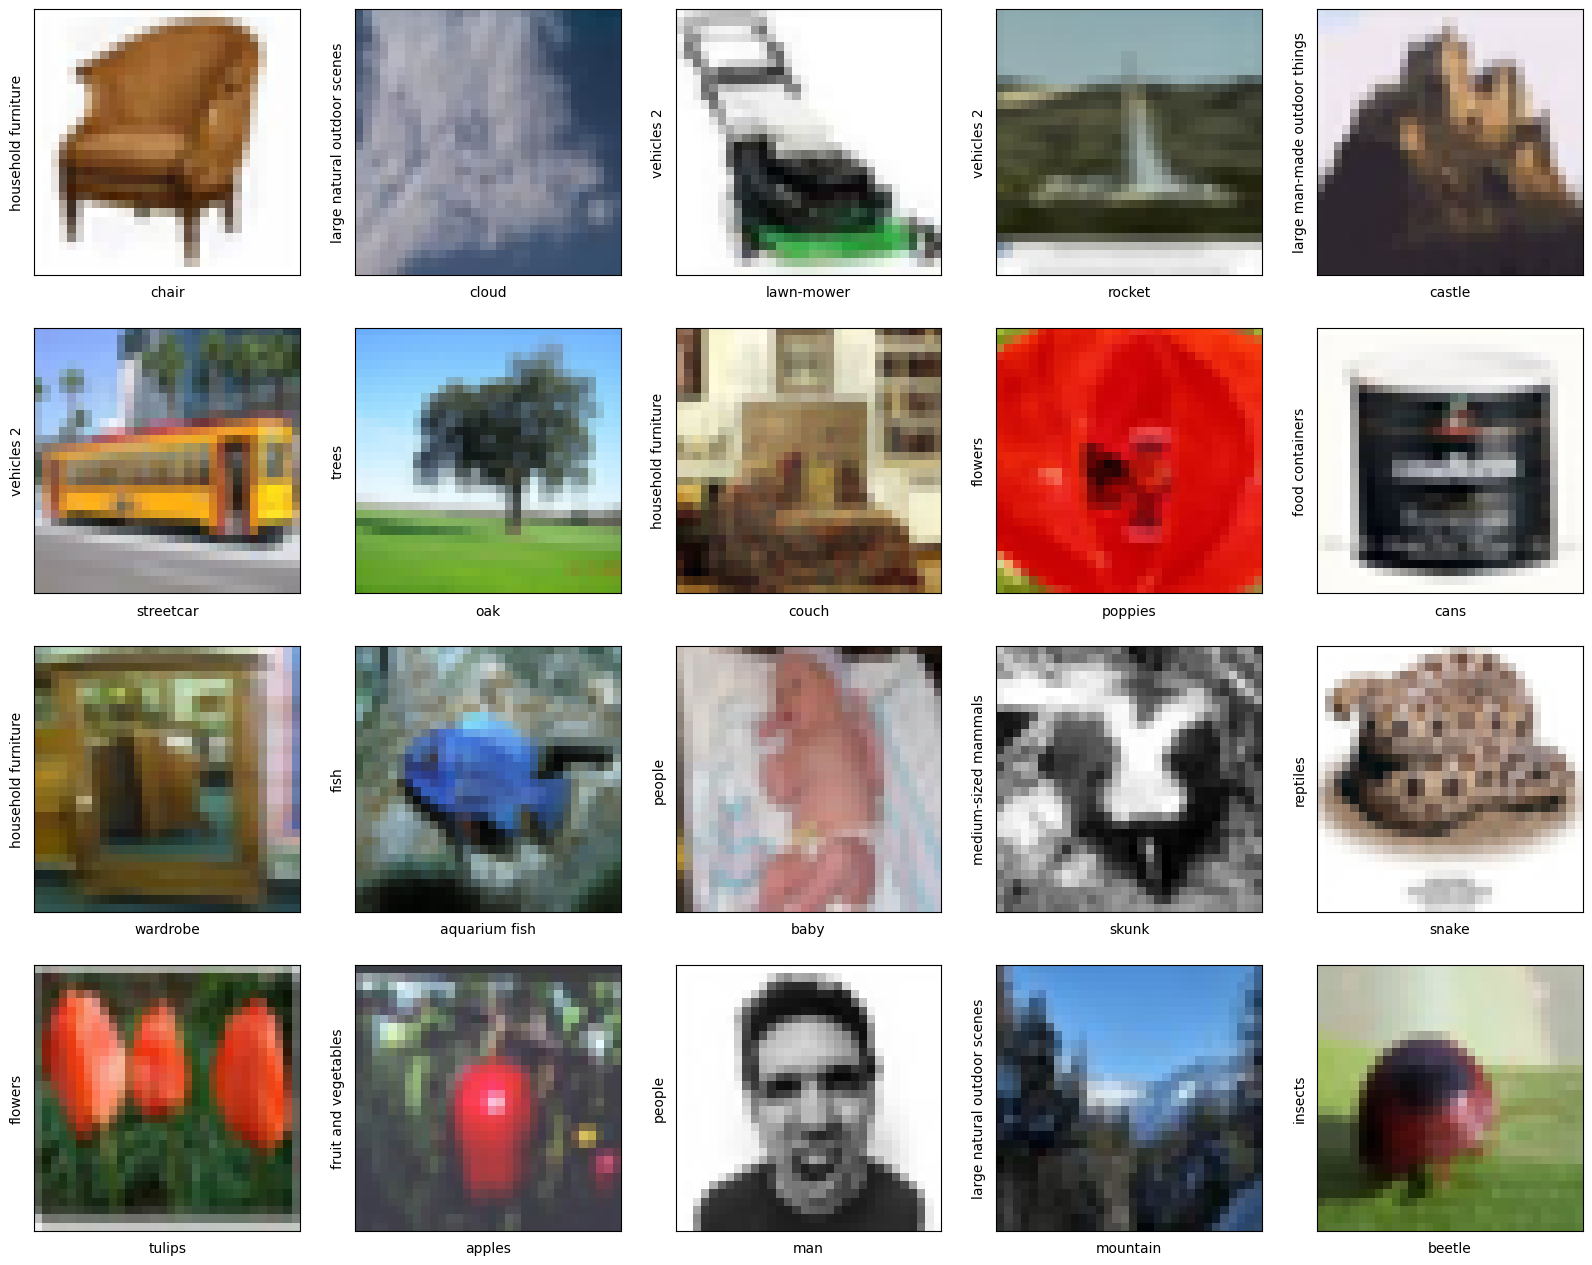

In [75]:
plt.figure(figsize=(20,20))

for i in range(0,20):
    x = random.randint(0, 49999)
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(trn[x])
    plt.xlabel(txtlb_fine[trnlb_fine[x]])
    plt.ylabel(txtlb_coarse[trnlb_coarse[x]])

plt.show()

# Data augmentation

We will need to make our labels categorical so they will work with the NN. This turns the data from a list of labels that looks like (8, 5, 6...) to this ((0, 0, 0, 0, 0, 0, 1, 0, 0...), (0, 0...)) which changes our data from form x,1 to x,20 (in the case of the coarse labels)

In [76]:
trnlb_coarse = to_categorical(trnlb_coarse)
tstlb_coarse = to_categorical(tstlb_coarse)

trnlb_fine = to_categorical(trnlb_fine)
tstlb_fine = to_categorical(tstlb_fine)

We will also need to flatten the data so that the model can use it

In [77]:
trn_flat = np.reshape(trn, (50000, 3072))
tst_flat = np.reshape(tst, (10000, 3072))

print(tst_flat.shape)
print(trn_flat.shape)
print(tst_flat[0])

(10000, 3072)
(50000, 3072)
[0.78039217 0.84313726 0.9764706  ... 0.6901961  0.6431373  0.7176471 ]


Centering the data so that it can be used with the sigmoid activation function

In [78]:
normaliser = StandardScaler()

norm_trn = normaliser.fit_transform(trn_flat)
norm_tst = normaliser.transform(tst_flat)
print(norm_trn[0])

[ 1.532512    1.5129677   1.446291   ...  0.13212073  0.633845
 -0.47497976]


# Coarse Model

Here we define our model and build it with the shape of our input data (after flattening) We have 1 input layer, 9 hidden layers and one output layer.

HL = Hidden Layer

Input layer - Dense layer - 2048 neurones using the sigmoid function

HL1 - Dropout layer of 20%

HL2 - Dense layer - 1024 neurones using the sigmoid function

HL3 - Dropout layer of 20%

HL4 - Dense layer - 512 neurones using the sigmoid function

HL5 - Dropout layer of 20%

HL6 - Dense layer - 246 neurones using the sigmoid function

HL7 - Dropout layer of 20%

HL8 - Dense layer - 128 neurones using the sigmoid function

HL9 - Dropout layer of 40%

Output HL1 - Dense layer - 20 neurones using the sigmoid function

In [79]:
model_coarse = tf.keras.Sequential(layers=[
    tf.keras.layers.Dense(2048, activation=tf.nn.sigmoid),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1024, activation=tf.nn.sigmoid),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation=tf.nn.sigmoid),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation=tf.nn.sigmoid),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation=tf.nn.sigmoid),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(coarse, activation=tf.nn.softmax)])
model_coarse.build(input_shape=(trn_flat.shape))
model_coarse.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (50000, 2048)             6293504   
                                                                 
 dropout_20 (Dropout)        (50000, 2048)             0         
                                                                 
 dense_25 (Dense)            (50000, 1024)             2098176   
                                                                 
 dropout_21 (Dropout)        (50000, 1024)             0         
                                                                 
 dense_26 (Dense)            (50000, 512)              524800    
                                                                 
 dropout_22 (Dropout)        (50000, 512)              0         
                                                                 
 dense_27 (Dense)            (50000, 256)             

Here we define the optimiser for our model and how it will measure its accuracy. I have chosen a learning rate of 0.1 as it gave the best results

In [80]:
opt = SGD(lr=0.1, momentum=0.9)
model_coarse.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

C:\Python310\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


We run our model for 100 epochs and split the data so 20% of it is used for validation

In [81]:
history_coarse = model_coarse.fit(
    norm_trn, 
    trnlb_coarse,
    epochs=100,
    verbose=1,
    validation_split=0.2
)

Epoch 1/100
1250/1250 [==============================] - 8s 6ms/step - loss: 3.0081 - accuracy: 0.0501 - val_loss: 3.0057 - val_accuracy: 0.0482
Epoch 2/100
1250/1250 [==============================] - 7s 6ms/step - loss: 3.0034 - accuracy: 0.0504 - val_loss: 3.0099 - val_accuracy: 0.0482
Epoch 3/100
1250/1250 [==============================] - 7s 6ms/step - loss: 3.0040 - accuracy: 0.0485 - val_loss: 2.9993 - val_accuracy: 0.0518
Epoch 4/100
1250/1250 [==============================] - 11s 9ms/step - loss: 3.0039 - accuracy: 0.0490 - val_loss: 3.0007 - val_accuracy: 0.0461
Epoch 5/100
1250/1250 [==============================] - 9s 7ms/step - loss: 3.0031 - accuracy: 0.0499 - val_loss: 3.0051 - val_accuracy: 0.0482
Epoch 6/100
1250/1250 [==============================] - 8s 7ms/step - loss: 3.0031 - accuracy: 0.0490 - val_loss: 3.0140 - val_accuracy: 0.0461
Epoch 7/100
1250/1250 [==============================] - 8s 7ms/step - loss: 3.0039 - accuracy: 0.0499 - val_loss: 3.0046 - val_a

1250/1250 [==============================] - 7s 6ms/step - loss: 1.5182 - accuracy: 0.5178 - val_loss: 2.2751 - val_accuracy: 0.3592
Epoch 58/100
1250/1250 [==============================] - 7s 6ms/step - loss: 1.5081 - accuracy: 0.5254 - val_loss: 2.3546 - val_accuracy: 0.3535
Epoch 59/100
1250/1250 [==============================] - 7s 6ms/step - loss: 1.4933 - accuracy: 0.5268 - val_loss: 2.3086 - val_accuracy: 0.3534
Epoch 60/100
1250/1250 [==============================] - 7s 6ms/step - loss: 1.4778 - accuracy: 0.5307 - val_loss: 2.3245 - val_accuracy: 0.3546
Epoch 61/100
1250/1250 [==============================] - 7s 6ms/step - loss: 1.4672 - accuracy: 0.5343 - val_loss: 2.2717 - val_accuracy: 0.3565
Epoch 62/100
1250/1250 [==============================] - 7s 6ms/step - loss: 1.4720 - accuracy: 0.5317 - val_loss: 2.2996 - val_accuracy: 0.3555
Epoch 63/100
1250/1250 [==============================] - 7s 6ms/step - loss: 1.4402 - accuracy: 0.5428 - val_loss: 2.3399 - val_accuracy

We can see that from our training graphs the model starts to overfit by epoch 25ish which is not very good, however this is the best I could get the model to achieve.

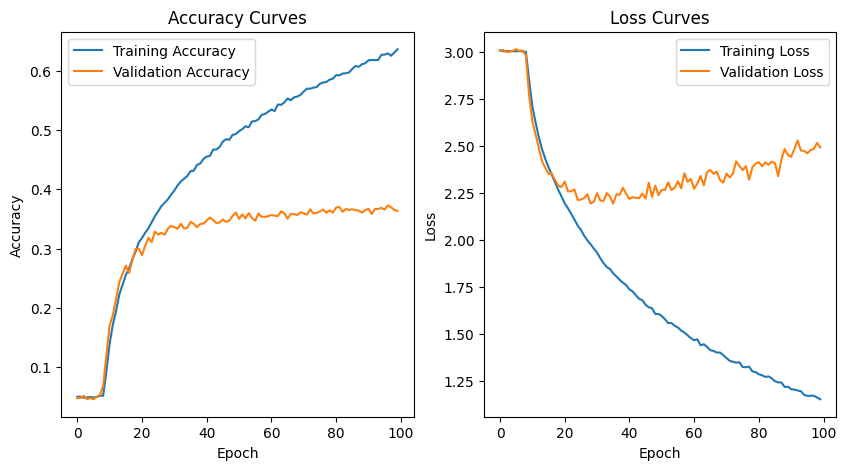

In [82]:
plt.figure(figsize=[10,5])
plt.subplot(121)
plt.plot(history_coarse.history['accuracy'])
plt.plot(history_coarse.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy',
           'Validation Accuracy'])
plt.title('Accuracy Curves')

plt.subplot(122)
plt.plot(history_coarse.history['loss'])
plt.plot(history_coarse.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss',
           'Validation Loss'])
plt.title('Loss Curves')
plt.show()

The model gets an accuracy of 36% when given the test data

In [83]:
results = model_coarse.evaluate(norm_tst, tstlb_coarse)

print(f'Test set loss: {results[0]:0.2f}, test set accuracy: {results[1]*100:0.2f}%')

313/313 [==============================] - 1s 3ms/step - loss: 2.5122 - accuracy: 0.3556
Test set loss: 2.51, test set accuracy: 35.56%


# Fine model

Here we define our model and build it with the shape of our input data (after flattening) We have 1 input layer, 9 hidden layers and one output layer.

HL = Hidden Layer

Input layer - Dense layer - 2048 neurones using the sigmoid function

HL1 - Dropout layer of 20%

HL2 - Dense layer - 1024 neurones using the sigmoid function

HL3 - Dropout layer of 20%

HL4 - Dense layer - 512 neurones using the sigmoid function

HL5 - Dropout layer of 20%

HL6 - Dense layer - 246 neurones using the sigmoid function

HL7 - Dropout layer of 20%

HL8 - Dense layer - 128 neurones using the sigmoid function

HL9 - Dropout layer of 40%

Output HL1 - Dense layer - 100 neurones using the sigmoid function

In [84]:
model_fine = tf.keras.Sequential(layers=[
    tf.keras.layers.Dense(2048, activation=tf.nn.sigmoid),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1024, activation=tf.nn.sigmoid),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation=tf.nn.sigmoid),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation=tf.nn.sigmoid),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation=tf.nn.sigmoid),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(fine, activation=tf.nn.softmax)])
model_fine.build(input_shape=(trn_flat.shape))
model_fine.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (50000, 2048)             6293504   
                                                                 
 dropout_25 (Dropout)        (50000, 2048)             0         
                                                                 
 dense_31 (Dense)            (50000, 1024)             2098176   
                                                                 
 dropout_26 (Dropout)        (50000, 1024)             0         
                                                                 
 dense_32 (Dense)            (50000, 512)              524800    
                                                                 
 dropout_27 (Dropout)        (50000, 512)              0         
                                                                 
 dense_33 (Dense)            (50000, 256)             

We are using the same opimiser and accracy metrics for this model

In [85]:
model_fine.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

Again, training for 100 epochs and splitting the data into 20% validataion

In [86]:
history_fine = model_fine.fit(
    norm_trn, 
    trnlb_fine,
    epochs=100,
    verbose=1,
    validation_split=0.2
)

Epoch 1/100
1250/1250 [==============================] - 8s 6ms/step - loss: 4.6171 - accuracy: 0.0101 - val_loss: 4.6165 - val_accuracy: 0.0098
Epoch 2/100
1250/1250 [==============================] - 7s 6ms/step - loss: 4.6141 - accuracy: 0.0098 - val_loss: 4.6144 - val_accuracy: 0.0105
Epoch 3/100
1250/1250 [==============================] - 7s 6ms/step - loss: 4.6141 - accuracy: 0.0090 - val_loss: 4.6118 - val_accuracy: 0.0109
Epoch 4/100
1250/1250 [==============================] - 7s 6ms/step - loss: 4.6139 - accuracy: 0.0096 - val_loss: 4.6128 - val_accuracy: 0.0087
Epoch 5/100
1250/1250 [==============================] - 7s 6ms/step - loss: 4.6138 - accuracy: 0.0093 - val_loss: 4.6156 - val_accuracy: 0.0091
Epoch 6/100
1250/1250 [==============================] - 7s 6ms/step - loss: 4.6140 - accuracy: 0.0098 - val_loss: 4.6175 - val_accuracy: 0.0095
Epoch 7/100
1250/1250 [==============================] - 7s 6ms/step - loss: 4.6135 - accuracy: 0.0097 - val_loss: 4.6144 - val_ac

1250/1250 [==============================] - 7s 6ms/step - loss: 2.8654 - accuracy: 0.2699 - val_loss: 3.3621 - val_accuracy: 0.2067
Epoch 58/100
1250/1250 [==============================] - 7s 6ms/step - loss: 2.8551 - accuracy: 0.2745 - val_loss: 3.3329 - val_accuracy: 0.2182
Epoch 59/100
1250/1250 [==============================] - 7s 6ms/step - loss: 2.8450 - accuracy: 0.2727 - val_loss: 3.3448 - val_accuracy: 0.2193
Epoch 60/100
1250/1250 [==============================] - 7s 6ms/step - loss: 2.8274 - accuracy: 0.2776 - val_loss: 3.3501 - val_accuracy: 0.2230
Epoch 61/100
1250/1250 [==============================] - 7s 6ms/step - loss: 2.8011 - accuracy: 0.2835 - val_loss: 3.3448 - val_accuracy: 0.2202
Epoch 62/100
1250/1250 [==============================] - 7s 6ms/step - loss: 2.7907 - accuracy: 0.2860 - val_loss: 3.3643 - val_accuracy: 0.2221
Epoch 63/100
1250/1250 [==============================] - 7s 6ms/step - loss: 2.7774 - accuracy: 0.2902 - val_loss: 3.3383 - val_accuracy

Once again the model starts to overfit at epoch 25 but this was the best I could achieve.

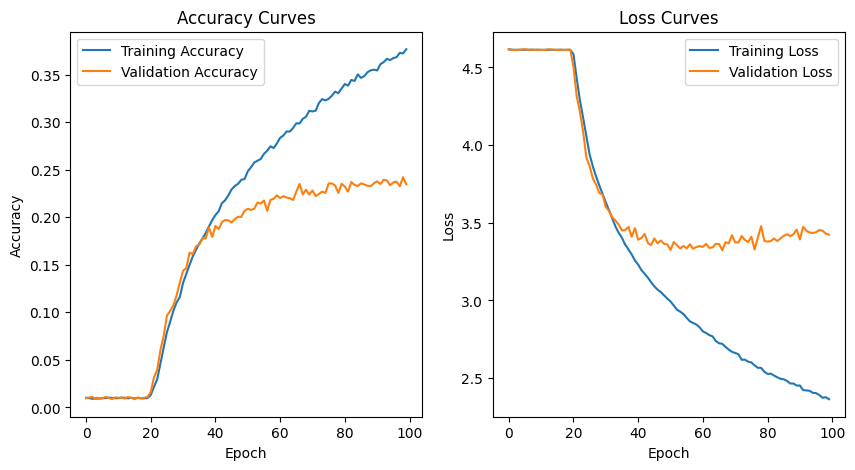

In [87]:
plt.figure(figsize=[10,5])
plt.subplot(121)
plt.plot(history_fine.history['accuracy'])
plt.plot(history_fine.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy',
           'Validation Accuracy'])
plt.title('Accuracy Curves')

plt.subplot(122)
plt.plot(history_fine.history['loss'])
plt.plot(history_fine.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss',
           'Validation Loss'])
plt.title('Loss Curves')
plt.show()

It manages to get an accuracy of 23% for the fine labels

In [88]:
results = model_fine.evaluate(norm_tst, tstlb_fine)

print(f'Test set loss: {results[0]:0.2f}, test set accuracy: {results[1]*100:0.2f}%')

313/313 [==============================] - 1s 3ms/step - loss: 3.4122 - accuracy: 0.2371
Test set loss: 3.41, test set accuracy: 23.71%


# Evaluation

Lets generate some predicted labels for our test data to see the outcome of our model more clearly.

In [89]:
pred_fine = model_fine.predict(tst_flat)
pred_coarse = model_coarse.predict(tst_flat)

313/313 [==============================] - 1s 2ms/step


We need to convert our labels back into a 1 dimensional array so we just take the index of the highest value in our models predictions

In [90]:
predlb_fine = tf.argmax(pred_fine,1)
truelb_fine = tf.argmax(tstlb_fine,1)

predlb_coarse = tf.argmax(pred_coarse,1)
truelb_coarse = tf.argmax(tstlb_coarse,1)

In [91]:
print(predlb_fine)

tf.Tensor([ 8 99 15 ... 18 20 36], shape=(10000,), dtype=int64)


## Coarse Model

We can use this to create a confusion matrix for our coarse model

In [92]:
conf_matrix_coarse = tf.math.confusion_matrix(truelb_coarse, predlb_coarse, coarse)

Plotting it we can see that there is a lot of misclassification (this makes sense with a 36% accuracy) The concern is that the misclassification seem to be almost random. If the model was doing a good job we could expect it to only have crossover between similar catagories but our model is guessing catagories that dont make sense such as aquatic mammals and large man made outdoor things.

<AxesSubplot: >

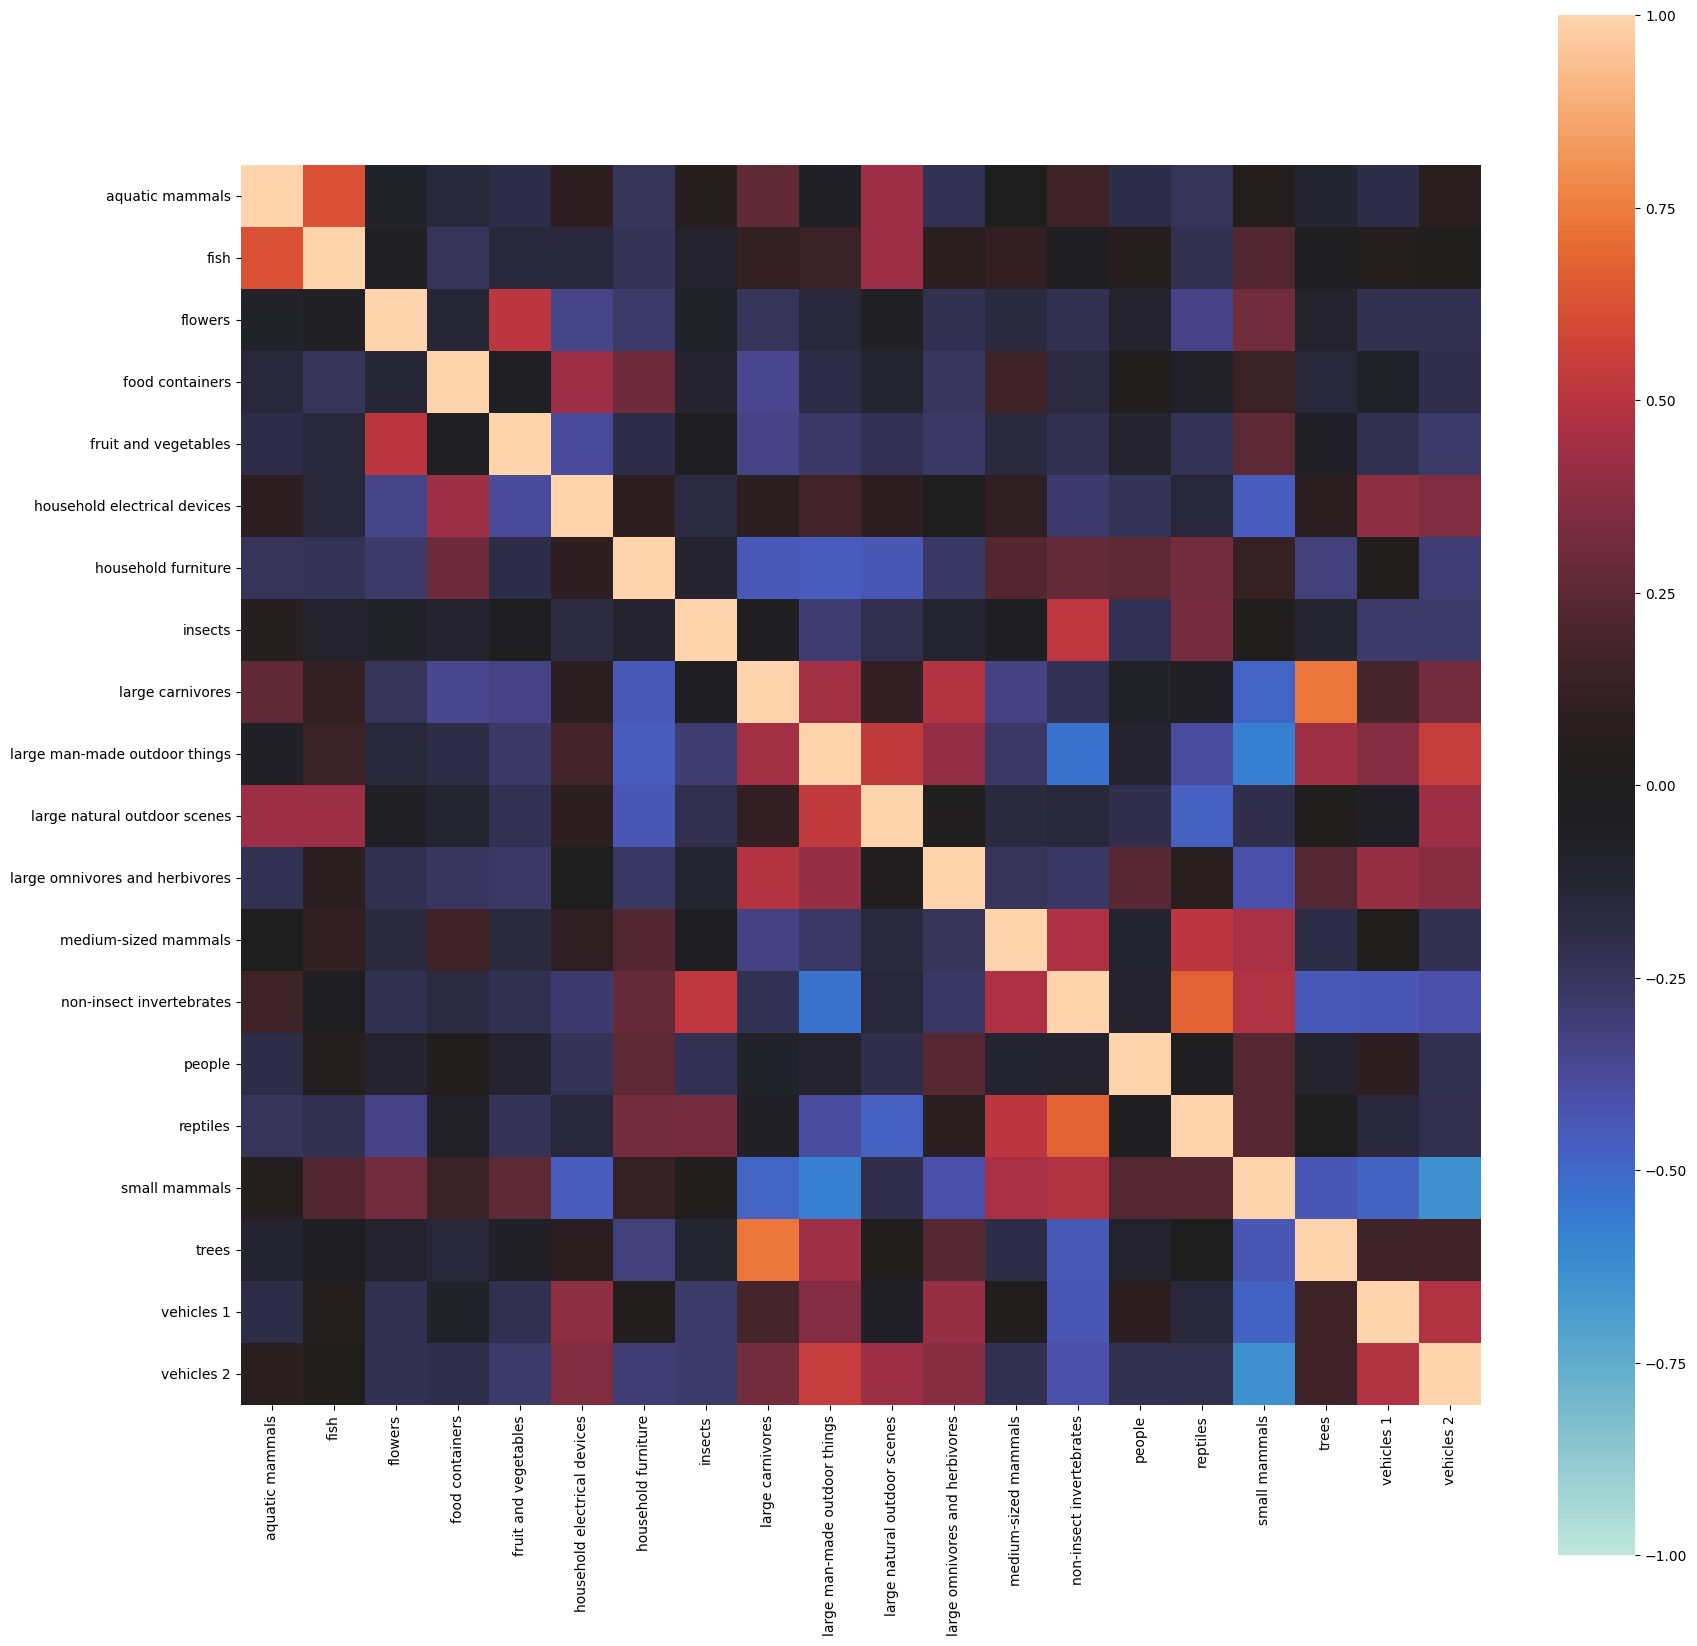

In [93]:
df = pd.DataFrame(conf_matrix_coarse, columns = txtlb_coarse)
df_corr = df.corr()

fig, ax = plt.subplots(figsize=(20, 20)) 
sns.heatmap(df_corr, square=True, vmax=1, vmin=-1, center=0)

Lets look at an example of misclassification. Here we label the models guess on the y axis and the real label on the x axis.

(32, 32, 3)


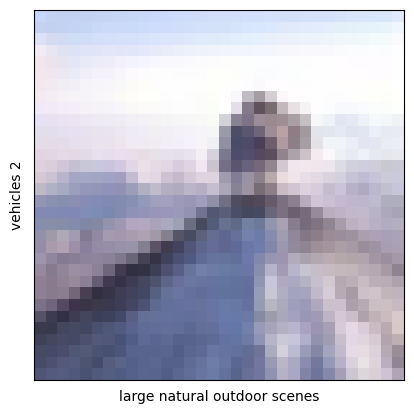

In [94]:
n = 0
flag = True
while flag == True:
    for images in tst:
        if predlb_coarse[n] == truelb_coarse[n]:
            n += 1
        else:
            flag = False
miss_img_coarse = tst[n]
print(miss_img_coarse.shape)
plt.xlabel(np.array(txtlb_coarse)[truelb_coarse[n]])
plt.ylabel(np.array(txtlb_coarse)[predlb_coarse[n]])
plt.xticks([])
plt.yticks([])
plt.imshow(miss_img_coarse)

We can plot the models guesses in each catagory here. It is prety confident that this is a vehicle which it is not. The real label is quite far down in its guess list. This may mean that it is biasing certain labels more than others.

<AxesSubplot: xlabel='Catagories'>

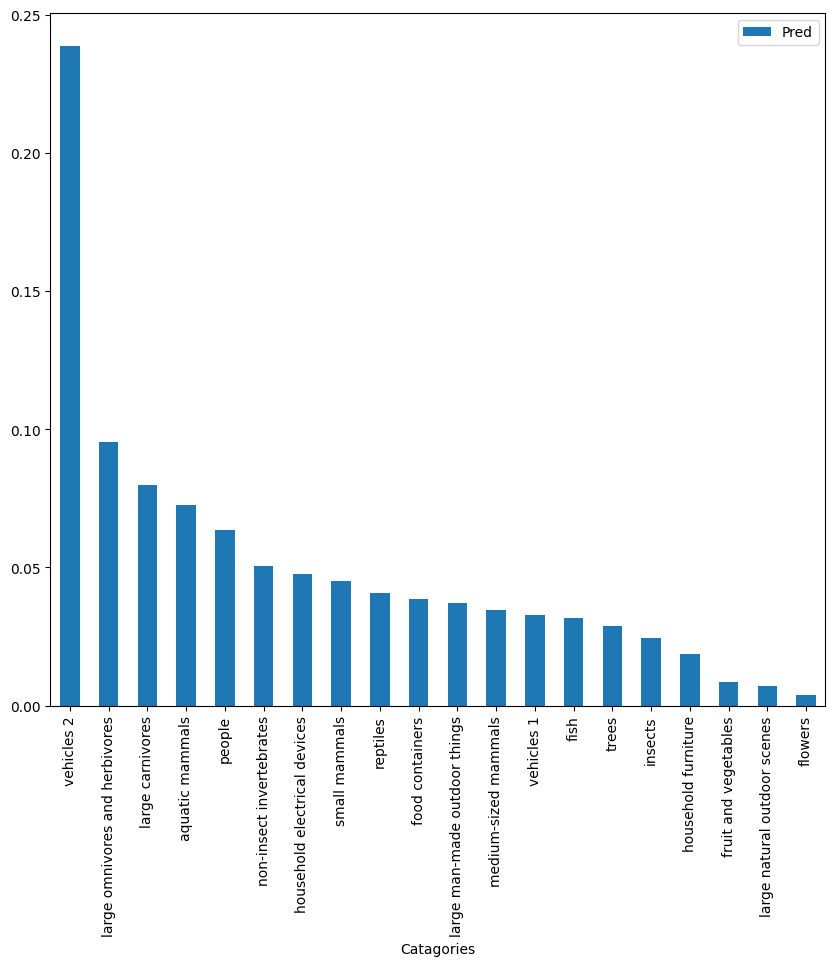

In [95]:
data = {"Catagories":txtlb_coarse,

        "Pred":pred_coarse[n]
        }

dataFrame = pd.DataFrame(data=data)
dataFrame.sort_values(by=['Pred'], inplace=True, ascending=False)
dataFrame.plot(x="Catagories", y="Pred", kind="bar", figsize=(10, 9))

## Fine model

Lets generate and load a confusion matrix for our fine model

In [96]:
conf_matrix_fine = tf.math.confusion_matrix(truelb_fine, predlb_fine, fine)

Here we can see that the model is very inaccurate and in some cases it hasnt even used some of the catagories.

In [97]:
df = pd.DataFrame(conf_matrix_fine, columns = txtlb_fine)
df_corr = df.corr()

fig, ax = plt.subplots(figsize=(100, 100)) 
sns.heatmap(df_corr, square=True, vmax=1, vmin=-1, center=0)

<AxesSubplot: >

We can print out the catagories that it hasnt chosen here by getting the difference between the catagories and predicted labels.

In [98]:
unique_pred_fine = np.unique(predlb_fine)
unique_true_fine = np.unique(truelb_fine)

print(len(unique_pred_fine))
print(len(unique_true_fine))

s = set(unique_true_fine)
temp = [txtlb_fine[x] for x in unique_true_fine if x not in unique_pred_fine]
print(temp)

93
100
['bear', 'beaver', 'bus', 'butterfly', 'pickup truck', 'porcupine', 'shark']


Lets load some images from one of these catagories and see what it has classified them as. Here I have chosen to look at some bus images. We can see the models guess on the X axis.

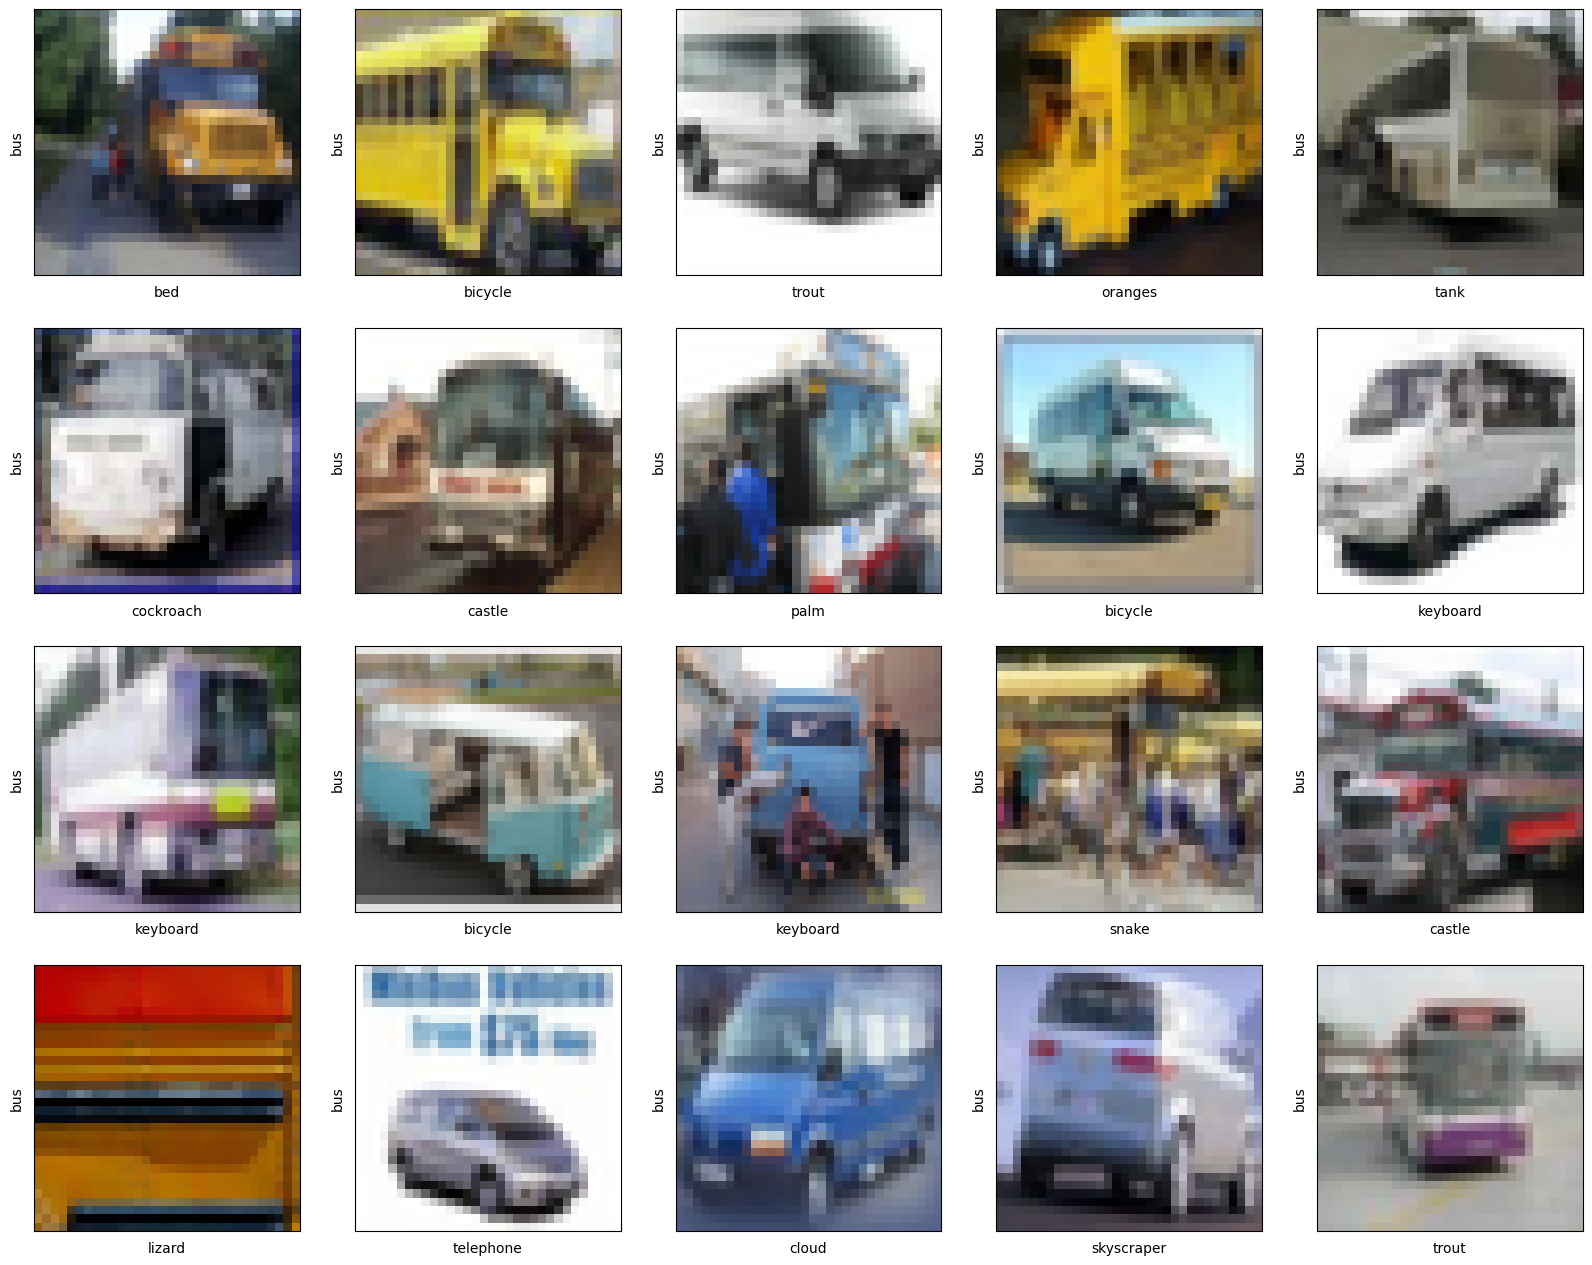

In [99]:
n = 0
bus_imgs = []
while len(bus_imgs) <= 5:
    for images in tst:
        if truelb_fine[n] == txtlb_fine.index('bus'):
            bus_imgs.append(n)
        n += 1 

plt.figure(figsize=(20,20))

for i in range(0,20):
    miss_img_fine = tst[bus_imgs[i]]
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(miss_img_fine)
    plt.ylabel(np.array(txtlb_fine)[truelb_fine[bus_imgs[i]]])
    plt.xlabel(np.array(txtlb_fine)[predlb_fine[bus_imgs[i]]])

plt.show()

Text(0, 0.5, 'bed')

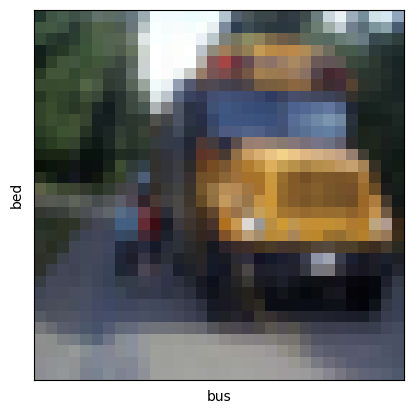

In [100]:
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(tst[bus_imgs[0]])
plt.xlabel(np.array(txtlb_fine)[truelb_fine[bus_imgs[0]]])
plt.ylabel(np.array(txtlb_fine)[predlb_fine[bus_imgs[0]]])

<AxesSubplot: xlabel='Catagories'>

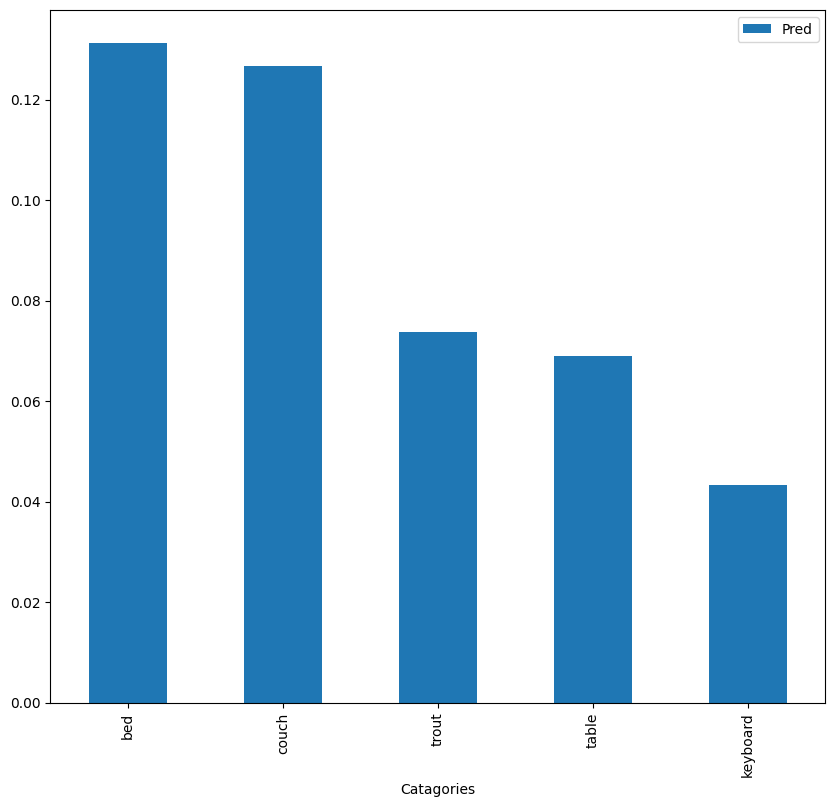

In [101]:
data = {"Catagories":txtlb_fine,
        "Pred":pred_fine[bus_imgs[0]]
        }

dataFrame = pd.DataFrame(data=data)
top_five = dataFrame.sort_values(by='Pred', ascending=False).head()
top_five.plot(x="Catagories", y="Pred", kind="bar", figsize=(10, 9))

(32, 32, 3)


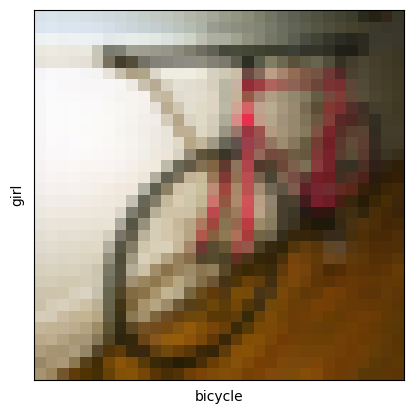

In [102]:
n = 0
flag = True
while flag == True:
    for images in tst:
        if predlb_coarse[n] == truelb_fine[n]:
            flag = False
        else:
            n += 1 
miss_img_fine = tst[n]
print(miss_img_fine.shape)
plt.xlabel(np.array(txtlb_fine)[truelb_fine[n]])
plt.ylabel(np.array(txtlb_fine)[predlb_fine[n]])
plt.xticks([])
plt.yticks([])
plt.imshow(miss_img_fine)

<AxesSubplot: xlabel='Catagories'>

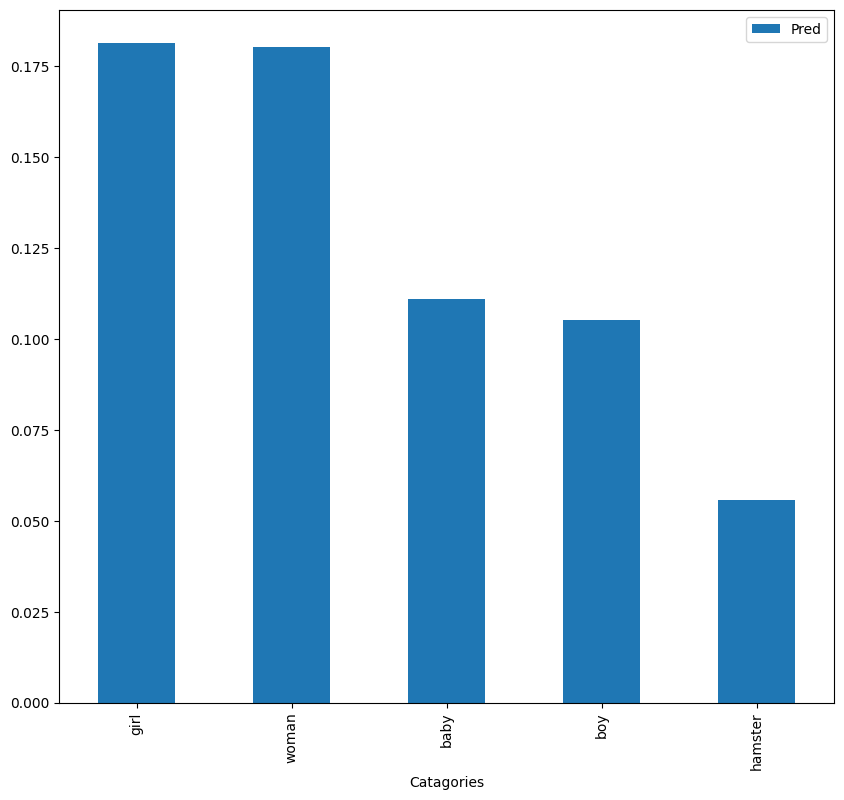

In [103]:
data = {"Catagories":txtlb_fine,
        "Pred":pred_fine[n]
        }

dataFrame = pd.DataFrame(data=data)
top_five = dataFrame.sort_values(by='Pred', ascending=False).head()
top_five.plot(x="Catagories", y="Pred", kind="bar", figsize=(10, 9))

(32, 32, 3)


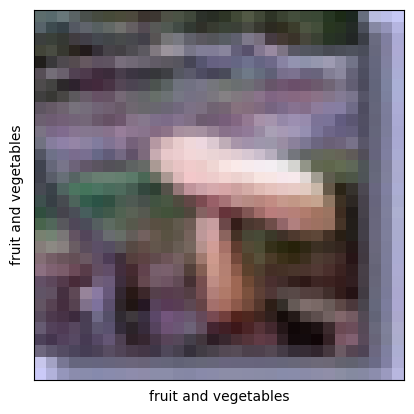

In [104]:
n = 0
flag = True
while flag == True:
    for images in tst:
        if predlb_coarse[n] == truelb_coarse[n]:
            flag = False
        else:
            n += 1 
miss_img_coarse = tst[n]
print(miss_img_coarse.shape)
plt.xlabel(np.array(txtlb_coarse)[truelb_coarse[n]])
plt.ylabel(np.array(txtlb_coarse)[predlb_coarse[n]])
plt.xticks([])
plt.yticks([])
plt.imshow(miss_img_coarse)

(32, 32, 3)


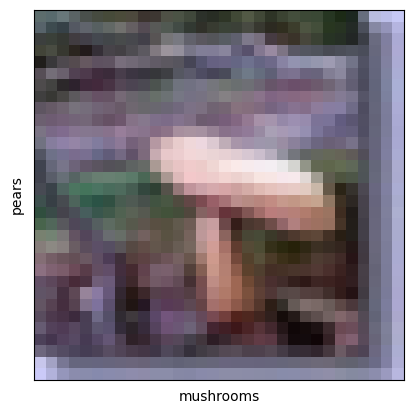

In [105]:
miss_img_fine = tst[n]
print(miss_img_fine.shape)
plt.xlabel(np.array(txtlb_fine)[truelb_fine[n]])
plt.ylabel(np.array(txtlb_fine)[predlb_fine[n]])
plt.xticks([])
plt.yticks([])
plt.imshow(miss_img_fine)

(32, 32, 3)


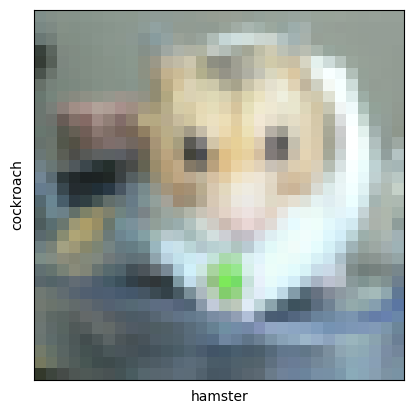

In [106]:
n = 0
flag = True
while flag == True:
    for images in tst:
        if truelb_fine[n] == txtlb_fine.index('hamster'):
            flag = False
        else:
            n += 1 
miss_img_fine = tst[n]
print(miss_img_fine.shape)
plt.xlabel(np.array(txtlb_fine)[truelb_fine[n]])
plt.ylabel(np.array(txtlb_fine)[predlb_fine[n]])
plt.xticks([])
plt.yticks([])
plt.imshow(miss_img_fine)